# Predicting the Presence of Breast Cancer
Approximately 1 in 8 U.S. women will develop invasive breast cancer over the course of her lifetime. Moreover, in 2019 about ~268,000 new cases of breast cancer will be diagnosed.
With such a high incidence, it would be ideal to have an automated and efficient way to diagnose patients.
We sought to make a prediction model with the capacity to diagnose cancer from a set of metrics that describe potentially cancerous tissue.

In [2]:
# Some data manipulation libraries
import pandas as pd
import numpy as np

# Bring in some plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

In [6]:
# Read in the data
df=pd.read_csv("../breast-cancer-wisconsin.csv",header=None,names=['id',
                                                      'Clump Thickness',
                                                      'Uniformity of Cell Size',
                                                      'Uniformity of Cell Shape',
                                                      'Marginal Adhesion',
                                                      'Single Epithelial Cell Size',
                                                      'Bare Nuclei',
                                                      'Bland Chromatin',
                                                      'Normal Nucleoli',
                                                      'Mitoses',
                                                      'Class']).set_index('id')

# Checking for missing data

We initially found no null values in our dataset, but noticed that the 'Bare Nuclei' column has an 'object' datatype, even though each column is supposed to be numeric. By counting the values in this column we found 16 rows (~2%) with a value of '?', indicating missing data. We replaced this value with actual Numpy NaNs, then changed the column data type to numeric.

In [7]:
print("Null values in each column:\n"+str(df.isna().sum())+'\n')
print("Data type for each column:\n"+str(df.dtypes)+'\n')
print("Value counts in 'Bare Nuclei' column:\n"+str(df['Bare Nuclei'].value_counts())+'\n')
df['Bare Nuclei'].replace('?',np.nan,inplace=True)
df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei'])
print("Number of benign cells with data for 'Bare Nuclei': "+str(len(df[df['Class']==2].dropna())))
print("Number of malignant cells with data for 'Bare Nuclei': "+str(len(df[df['Class']==4].dropna())))

Null values in each column:
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

Data type for each column:
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

Value counts in 'Bare Nuclei' column:
1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64

Number of benign cells wi

# Exploratory Data Analysis

In [8]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


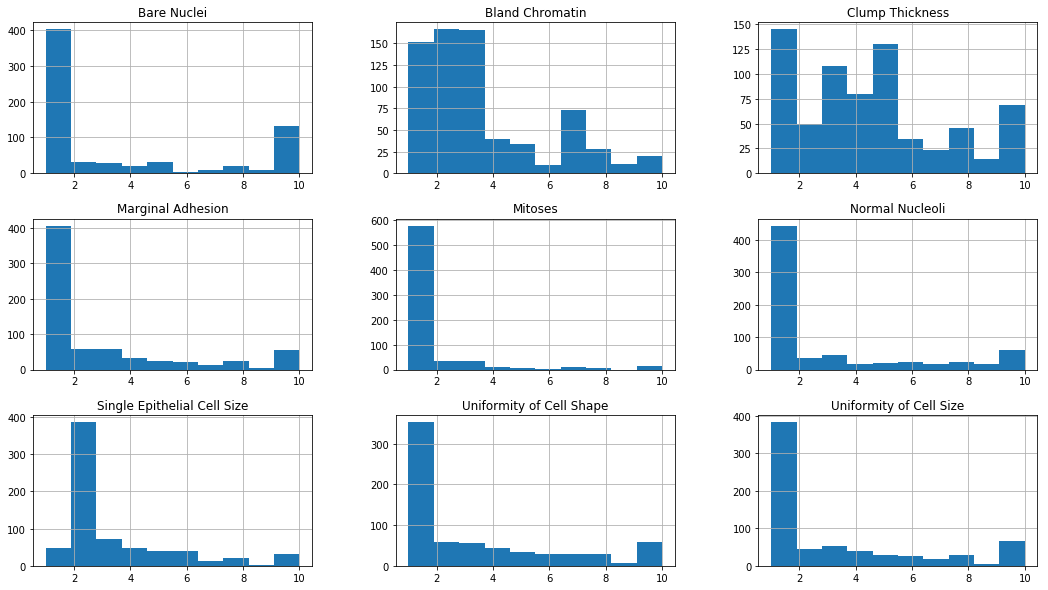

In [9]:
# Plot histograms to explore distributions
df[['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses']].hist(figsize=(18,10))
plt.show()

# Heatmap
We wonder if there is any correlation between features and target. To check for these, we used a Pearson’s correlation.

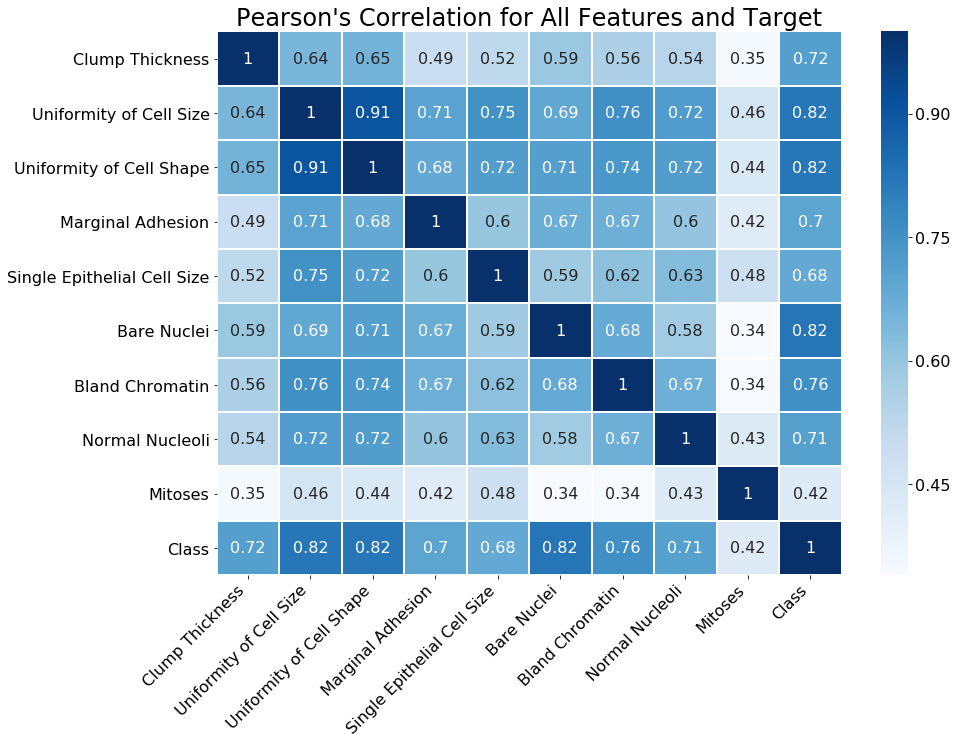

In [10]:
# Store the pearson correlations
pearsons_corr = df.corr()

# Set figure size
fig, ax = plt.subplots(figsize=(14,10))

# Create heatmap
sns.heatmap(pearsons_corr, annot=True, ax=ax, fmt='.2g', cmap='Blues', linewidths=1, annot_kws={'fontsize': 16})
plt.title("Pearson's Correlation for All Features and Target", fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)

#Increase font in scale
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)

This plot shows a weak correlation between mitoses and all features, a medium correlation between most of the rest of the features and a high correlation, and a high correlation between Uniformity of cell shape and Uniformity of cell size

# PCA Visualization

Dropping rows with an unknown value for the 'Bare Nuclei' parameter, PCA shows the first 2 principal components account for approximately 76% of the original of the variation in the original data, and the data itself is likely to be easily separable into the benign and malignant cell classes, with only ~20 (or ~5%) benign cells visibly mixed in with the cloud of malignant cell data.

Variance explained by first five components: [0.69050756 0.07195066 0.06055921 0.04442012 0.03900513]


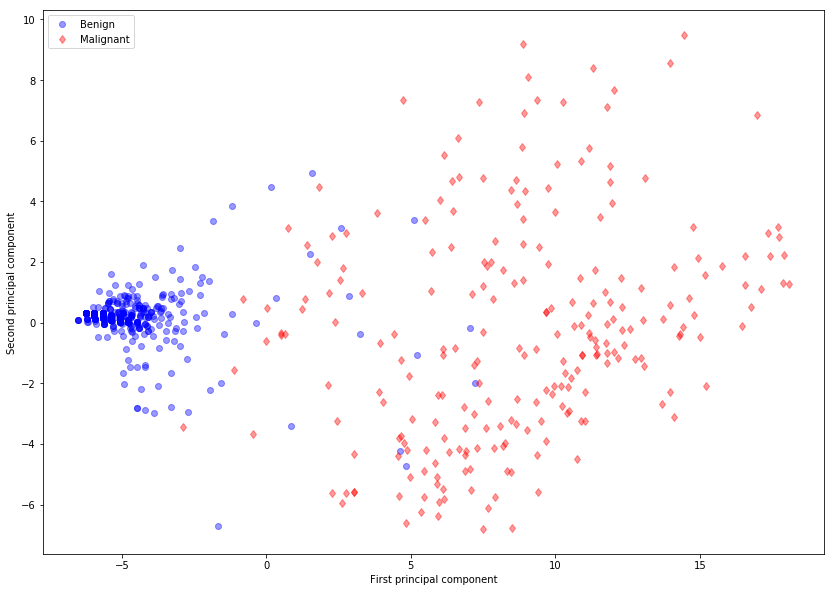

In [35]:
from sklearn.decomposition import PCA

# Run and fit PCA
pca = PCA(n_components=5)
pca.fit(df.dropna().values[:,:-1])
print("Variance explained by first five components: " +str(pca.explained_variance_ratio_))

# Set figure size
fig, ax = plt.subplots(figsize=(14,10))

# Plot PC 1 and PC 2 as a scatterplot
X_benign=pca.transform(df[df['Class']==2].dropna().values[:,:-1])
X_malign=pca.transform(df[df['Class']==4].dropna().values[:,:-1])
plt.plot(X_benign[:,0],X_benign[:,1],'o',c='b',alpha=0.4,label='Benign')
plt.plot(X_malign[:,0],X_malign[:,1],'d',c='r',alpha=0.4,label='Malignant')
plt.legend(loc='upper left')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()


# Random Forest Classifier

A random forest classifier gets an average ~95-96% F1 score in 5-fold cross-validation, using parameters defined by a grid search for each fold (number of folds and parameters shown here reduced from original test to run in a reasonable amount of time).

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

data=np.random.shuffle(np.copy(df.values))
X=df.dropna().values[:,:-1]
y=df.dropna().values[:,-1]

# 5-fold stratified train-testing split

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

accuracies=[]
precisions=[]
recalls=[]
rocs=[]
for train_index, test_index in skf.split(X, y):
    # Define training/testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf=RandomForestClassifier(n_estimators=128, n_jobs=-1)
    parameters = {'max_depth':[10,None],
                 'max_features':['sqrt','log2'],
                 'min_samples_split':[2,4],
                 'min_samples_leaf':[1,2]}
    
    # Grid search over parameters using 5-fold CV over training set
    clf = GridSearchCV(rf, parameters,n_jobs=-1,cv=5)
    clf.fit(X_train,y_train)
    preds=clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, preds))
    precisions.append(precision_score(y_test, preds,labels=[2,4],pos_label=4))
    recalls.append(recall_score(y_test, preds,labels=[2,4],pos_label=4))
    rocs.append(roc_auc_score(y_test,preds))

In [17]:
f1s=[2*precisions[i]*recalls[i]/(precisions[i]+recalls[i]) 
for i in range(len(precisions))]
print('Average accuracy %.2f%%' % (np.mean(accuracies)* 100.0))
print("Average precision %.2f%% " % (np.mean(precisions)* 100))
print("Average recall %.2f%% " % (np.mean(recalls)* 100))
print("Average AUC %.2f%% " % (np.mean(rocs)* 100))
print("Average F1 %.2f%% " % (np.mean(f1s)* 100))

Average accuracy 96.20%
Average precision 95.16% 
Average recall 94.16% 
Average AUC 95.73% 
Average F1 94.47% 


# SVC
SVC is a very powerful clasiffier with excellent performance for small to medium size datasets. Since our set is quiet small SVC can be a great option.

Initialy I started with a basic model and train it using 80% of the dataset.

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

%matplotlib inline

In [31]:
df = df.dropna()

X = df[['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses']]
y = df['Class']

# Splitting data between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make and SVC classifier
svc_clf = SVC(gamma='auto')

# Fitting the model with training data
svc_clf.fit(X_train, y_train) 

# Predictingon test data
test_pred = svc_clf.predict(X_test)

Since classes are a bit unbalance, accuracy score is not a good metric. Therefore, I use precision, recall, and weighted weighted f1 score to asses the performance of the model.

Precision and recall are both great measure because a low score in any of this metrics can have nefarious consequences in patients.

In [33]:
# Model optimization
# Parameters for GridSearch 
svc_param_grid = [{'C':[0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]

svc_clf_grid = SVC(gamma='auto')
svc_grid_search = GridSearchCV(estimator=svc_clf_grid, param_grid=svc_param_grid, cv=10, scoring='f1_weighted')

svc_grid_search.fit(X_train, y_train)

# Predict on test set using best estimator from GridSearch
test_pred_grided = svc_grid_search.best_estimator_.predict(X_test)

/Volumes/OWC_Big_Phatty/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
# Getting perfirmance metrics
print(metrics.classification_report(test_pred, y_test))
print('ROC AUC is:', metrics.roc_auc_score(test_pred_grided, y_test))

              precision    recall  f1-score   support

           2       0.94      0.99      0.96        75
           4       0.98      0.92      0.95        62

   micro avg       0.96      0.96      0.96       137
   macro avg       0.96      0.95      0.96       137
weighted avg       0.96      0.96      0.96       137

ROC AUC is: 0.9665188470066519


At first sight it may look that the model is performing a bit worse that the previous model. However, it shows an increase in recall for the positive class which is malignant cancer type. This is great because the model is correctly piccking up 98% of malignant cancers.

# Trying out XGBoost

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold

# Split into features and predictor 
X, y = df.iloc[:,:-1],df.iloc[:,-1]

# Encode the string predictor
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

# Add feature names
feature_names = ['Clump Thickness', 'Uniformity of Cell Size','Uniformity of Cell Shape', 'Marginal Adhesion',
                 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin','Normal Nucleoli', 'Mitoses']

data_dmatrix = xgb.DMatrix(data=X,label=y,feature_names=feature_names)


In [11]:
# Setup a timer to see how quickly the randomized grid search runs
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [12]:
# Train an initial xgboost model to test via randomized gridsearch
xgb_class = xgb.XGBClassifier(objective='binary:logistic', silent=True, nthread=1)

# A parameter grid to ramdonly select from for XGBoost with RandomizedSearchCV
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': [1, 2, 3, 4, 5, 10], 
        'n_estimators' : [100, 600, 1000, 1500],
        'learning_rate' : [.01, .1, .2, .5]
        }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_class, param_distributions=params, n_iter=param_comb, 
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



 Time taken: 0 hours 0 minutes and 15.19 seconds.


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   15.1s finished


In [13]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([1.12928931, 0.16088891, 1.78422093, 0.10469135, 1.4361488 ]), 'std_fit_time': array([0.11346505, 0.0205283 , 0.06977548, 0.05180509, 0.08048213]), 'mean_score_time': array([0.01554139, 0.01137233, 0.01803374, 0.00779494, 0.00706013]), 'std_score_time': array([0.00595357, 0.0094462 , 0.00816545, 0.00438307, 0.00231617]), 'param_subsample': masked_array(data=[0.9, 0.7, 0.6, 0.6, 0.7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000, 100, 1500, 100, 1500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 10, 1, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[2, 4, 4, 1, 3],
             mask=[False, False, False, False, False],
       fill_value

In [23]:
xgb_best =  xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                   colsample_bytree=0.8, gamma=0.5, learning_rate=0.2,
                   max_delta_step=0, max_depth=2, min_child_weight=5, missing=None,
                   n_estimators=1000, n_jobs=1, nthread=1, objective='binary:logistic',
                   random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                   seed=None, silent=True, subsample=0.9)

In [25]:
# Fit and generate predictions
xgb_best.fit(X, y)
preds = xgb_best.predict(X)

# Assess predictions
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       458
           1       0.96      0.98      0.97       241

   micro avg       0.98      0.98      0.98       699
   macro avg       0.98      0.98      0.98       699
weighted avg       0.98      0.98      0.98       699



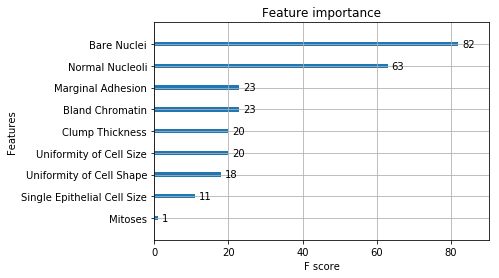

In [26]:
xgb.plot_importance(xgb_best)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()